# Nuclei segmentation

In [78]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import sklearn
import spateo as st
from scipy import ndimage

plt.rcParams['image.interpolation'] = 'none'
%config InlineBackend.figure_format='retina'

## Load the data

In [2]:
tif = skimage.io.imread('data/SS200000135IL-D1.ssDNA.tif')
total, exonic, intronic = st.read_bgi_agg('data/SS200000135TL_D1_all_bin1.txt.gz')

Text(0.5, 1.0, 'intronic')

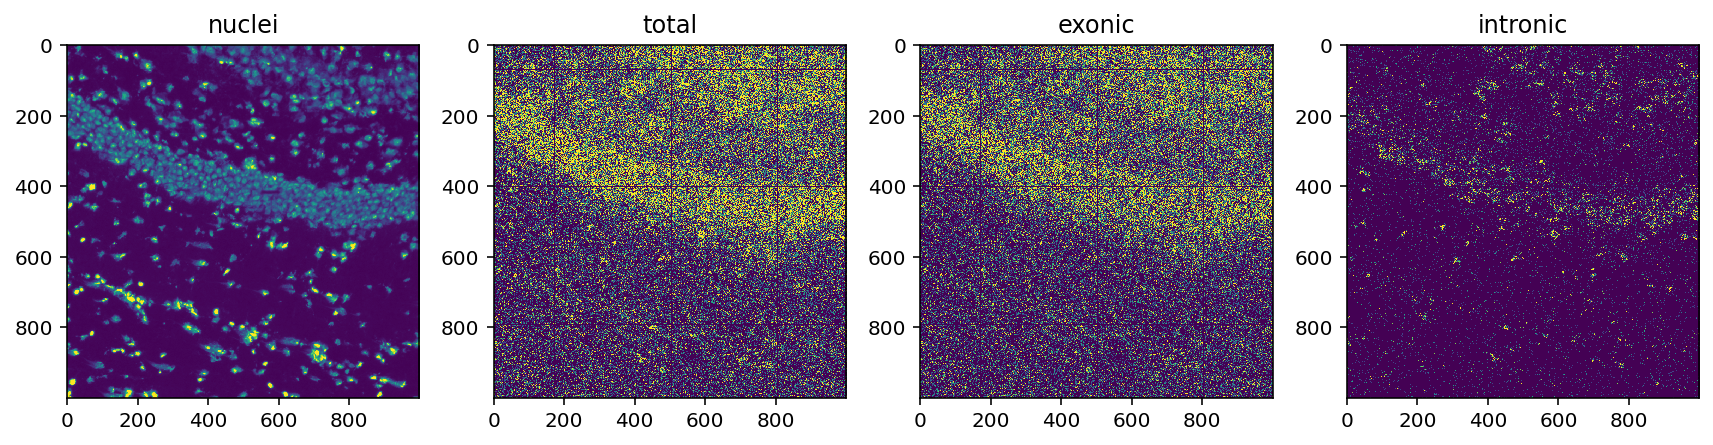

In [3]:
fig, axes = plt.subplots(ncols=4, figsize=(12, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')
axes[1].imshow(total.A, vmin=0, vmax=5)
axes[1].set_title('total')
axes[2].imshow(exonic.A, vmin=0, vmax=5)
axes[2].set_title('exonic')
axes[3].imshow(intronic.A, vmin=0, vmax=5)
axes[3].set_title('intronic')

## Segmentation using stained nuclei

Segmenting nuclei from staining result is relatively easy, since all we have to do is threshold the image to obtain a nuclei mask, and assign the mask to individual nuclei with watershed.

First, we will apply a global threshold using multi-class Otsu thresholding. This will classify each pixel into one of three bins based on all the intensities present in the image. We take all the pixels that are below the first threshold (i.e. classified into the first bin) to be background.

Text(0.5, 1.0, 'background segmentation')

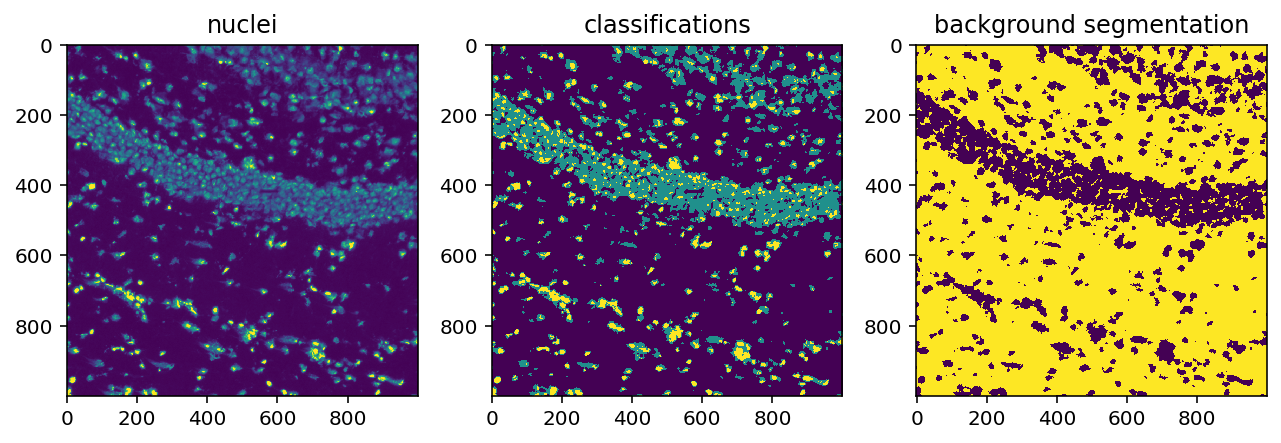

In [4]:
thresholds = skimage.filters.threshold_multiotsu(tif, 3)
regions = np.digitize(tif, bins=thresholds)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')

axes[1].imshow(regions)
axes[1].set_title('classifications')

background_mask = tif <= thresholds[0]
axes[2].imshow(background_mask)
axes[2].set_title('background segmentation')

Then, we separately apply a local (adaptive) thresholding method, which uses the local neighborhood of each pixel to determine the threshold for that pixel. This method is usually quite accurate (especially for images that have highly variable nuclei density), but becomes noisy in sparse areas.

Text(0.5, 1.0, 'local segmentation')

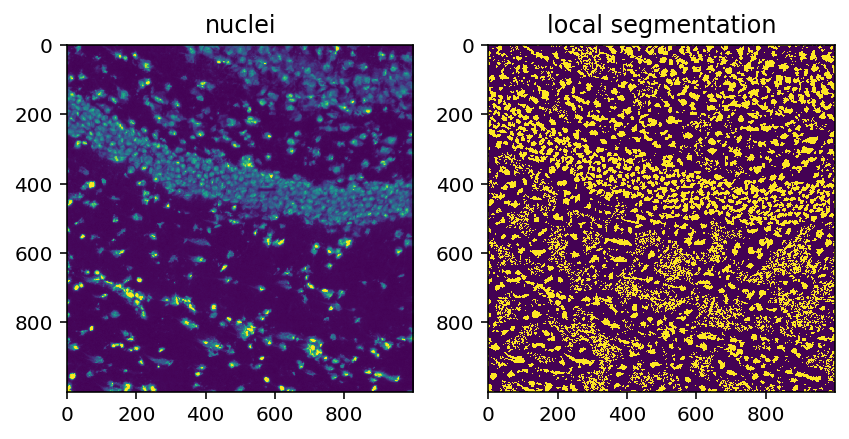

In [5]:
local_mask = tif > skimage.filters.threshold_local(tif, 45)
fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')

axes[1].imshow(local_mask)
axes[1].set_title('local segmentation')

Now, we use both the background mask (obtained via global thresholding) and the cell mask (obtained via local thresholding) to obtain the final mask.

Text(0.5, 1.0, 'nuclei segmentation')

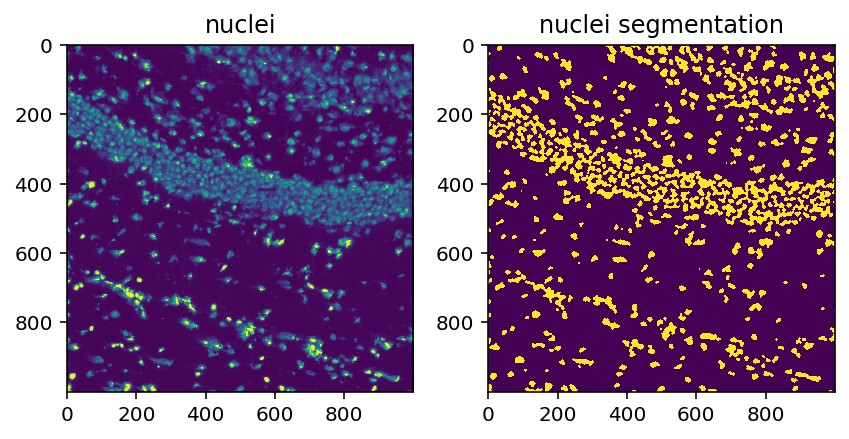

In [6]:
nuclei_mask = st.pp.segmentation.utils.mclose_mopen(
    (~background_mask) & local_mask, 7
)

fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')

axes[1].imshow(nuclei_mask)
axes[1].set_title('nuclei segmentation')

The function `st.pp.segmentation.icell.mask_nuclei_from_stain` combines all the above procedures into a single function.

Text(0.5, 1.0, 'nuclei segmentation')

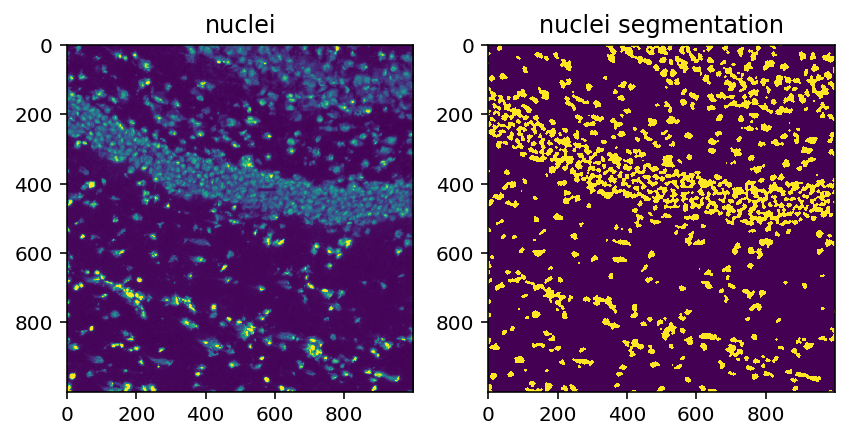

In [7]:
nuclei_mask = st.pp.segmentation.icell.mask_nuclei_from_stain(
    tif, otsu_classes=3, otsu_index=0, local_k=45, mk=7
)
fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')

axes[1].imshow(nuclei_mask)
axes[1].set_title('nuclei segmentation')

This does a pretty good job at identifying where nuclei are, but there are some noisy areas and regions where multiple nuclei are connected. We would like to separate individual nuclei. We can do so by using the Watershed algorithm. Note that this algorithm relies on a set of "markers" which will serve as seed regions for segmentation. Therefore, finding good markers is very important.

Here, we will use `st.pp.segmentation.utils.safe_erode`, which is a modification of the morphological erosion operation. Unlike the canonical operation, this function does not erode connected components that are less than the desired area. With these markers, we will apply the Watershed algorithm.

Text(0.5, 1.0, 'final segmentation')

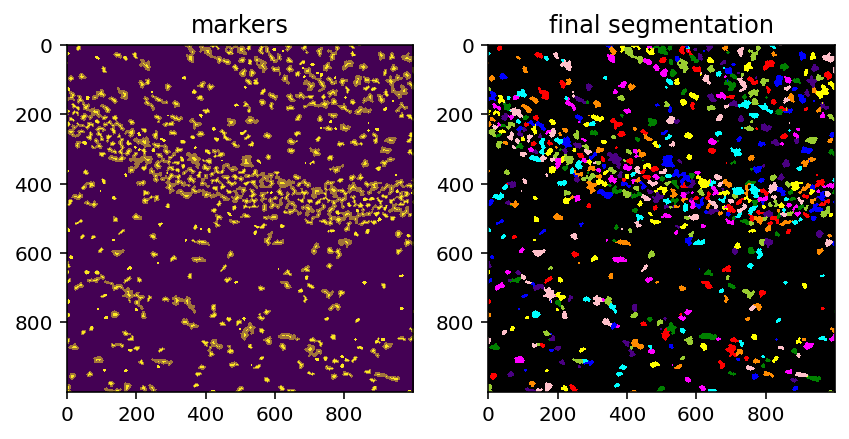

In [98]:
marker_mask = st.pp.segmentation.utils.safe_erode(
    nuclei_mask, 3, square=False, min_area=100, n_iter=10
)
watershed = st.pp.segmentation.label.watershed(
    tif, nuclei_mask, marker_mask, 5
)

fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
axes[0].imshow(nuclei_mask)
axes[0].imshow(marker_mask, alpha=0.5)
axes[0].set_title('markers')

axes[1].imshow(skimage.color.label2rgb(watershed, bg_label=0))
axes[1].set_title('final segmentation')

## Segmentation using (intronic) RNA signal

When stained nuclei are not available, it is possible to identify nuclei using intronic RNA. This approach, however, relies on the mis-priming of pre-processed intronic RNA onto the polyA nanoballs. Therefore, it is not reasonable to expect that we will be able to identify nearly as many nuclei as we did with the staining image due to overall low (intron) capture rate, technical and biological noise, and RNA diffusion.

In this part, we assume that we do not have access to the nuclei staining image. In the end, we will compare the results with the nuclei segmented using staining (above).

First, we will try and separate out regions that do not have nuclei, and regions that do. Observe that we apply the EM algorithm followed by belief propagation (`method='EM+BP'`), which gives us the propbability, at each pixel, that the pixel is occupied. Then, we find Otsu thresholds of these probabilities, assigning pixels into three bins. The pixels in the second and third bins will be used as an overall mask, whereas pixels in only the third bin will be used to identify markers for the Watershed algorithm.

Text(0.5, 1.0, 'nuclei segmentation')

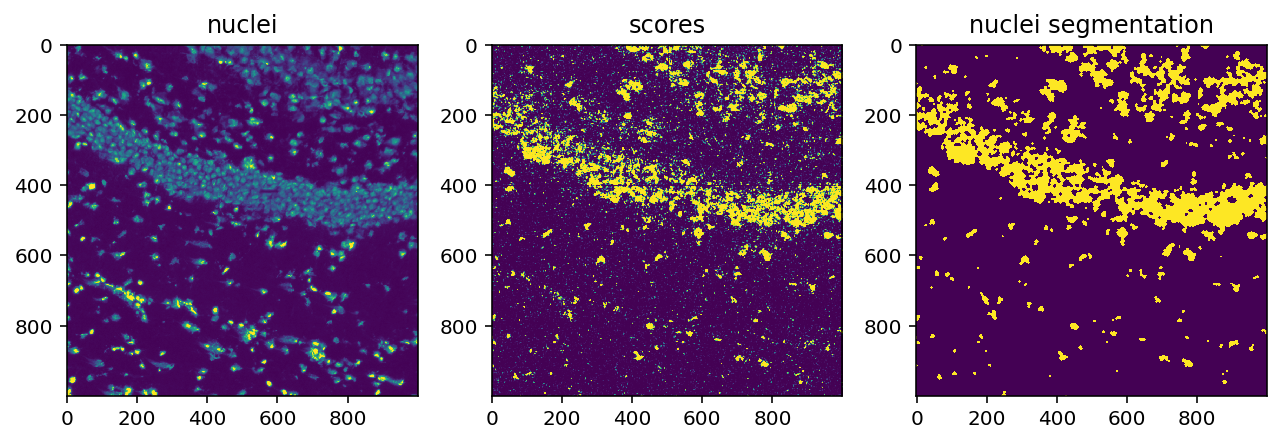

In [11]:
scores = st.pp.segmentation.icell.score_pixels(
    intronic,
    k=5,
    method='EM+BP',
    em_kwargs=dict(downsample=100000),
    bp_kwargs=dict(n_threads=8, k=3, square=False, p=2 / 3, q=1 / 3),
)
thresholds = skimage.filters.threshold_multiotsu(scores, classes=3)
est_nuclei_mask = st.pp.segmentation.utils.apply_threshold(scores, 7, thresholds[0])

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')

axes[1].imshow(scores)
axes[1].set_title('scores')

axes[2].imshow(est_nuclei_mask)
axes[2].set_title('nuclei segmentation')

Text(0.5, 1.0, 'final segmentation')

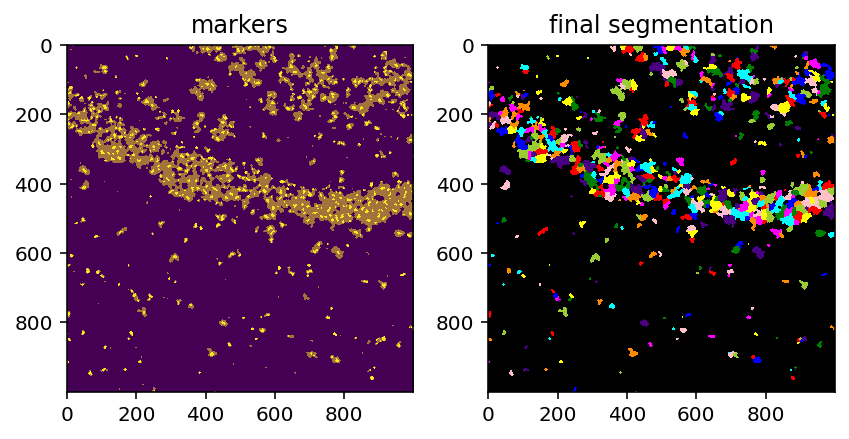

In [40]:
est_marker_mask = st.pp.segmentation.utils.safe_erode(
    scores, 3, square=False, min_area=100, n_iter=10, float_k=5, float_threshold=thresholds[1]
)
est_watershed = st.pp.segmentation.label.watershed(
    intronic.A, est_nuclei_mask, est_marker_mask, 9
)

fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
axes[0].imshow(est_nuclei_mask)
axes[0].imshow(est_marker_mask, alpha=0.5)
axes[0].set_title('markers')

axes[1].imshow(skimage.color.label2rgb(est_watershed, bg_label=0))
axes[1].set_title('final segmentation')

## Performance benchmarks

A key question is: how well does RNA-based nuclei segmentation perform? To answer this question, we will compare the nuclei segmentation done with staining against the RNA-based results.

Text(0.5, 1.0, 'RNA mask')

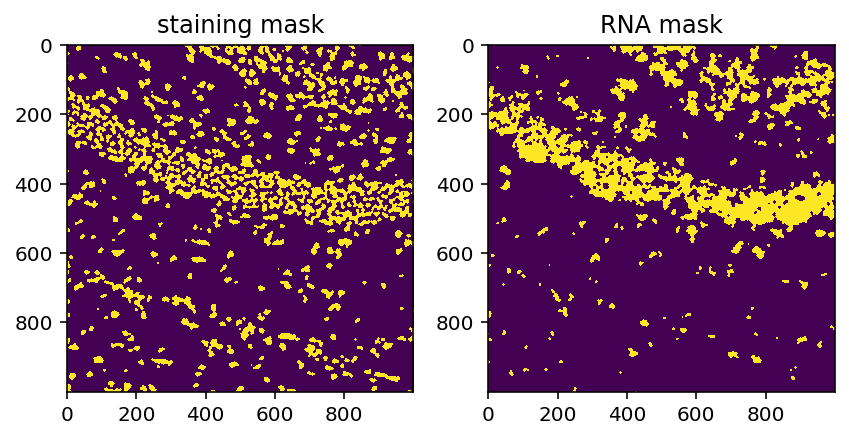

In [147]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
watershed_mask = watershed > 0
est_watershed_mask = est_watershed > 0

axes[0].imshow(watershed_mask)
axes[0].set_title('staining mask')

axes[1].imshow(est_watershed_mask)
axes[1].set_title('RNA mask')

At the most basic level, we can compare the two masks by imagining this to be a classification task. These rates are a combination of multiple factors, ranging from the sensitivity of the assay itself (its ability to detect mRNA) to the correctness and robustness of the algorithm.

In [148]:
y_true, y_pred = watershed_mask.flatten(), est_watershed_mask.flatten()
pos = y_true.sum()
neg = (~y_true).sum()
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_true, y_pred).ravel()
f1_score = sklearn.metrics.f1_score(y_true, y_pred)
print(f'True negative: {tn / neg:.3f}')
print(f'False positive: {fp / neg:.3f}')
print(f'False negative: {fn / pos:.3f}')
print(f'True positive: {tp / pos:.3f}')
print(f'F1 score: {f1_score:.3f}')

True negative: 0.903
False positive: 0.097
False negative: 0.571
True positive: 0.429
F1 score: 0.456


In the following sections, we will focus on specific areas that affect the above rates.

First is the dropout rate: how many nuclei we are unable to detect, most likely due to the sensitivity of the assay itself. This can be calculated by counting how many nuclei at least some percent covered by our RNA-based nuclei mask.

Text(0, 0.5, 'Nuclei with $\\geq$ capture proportion')

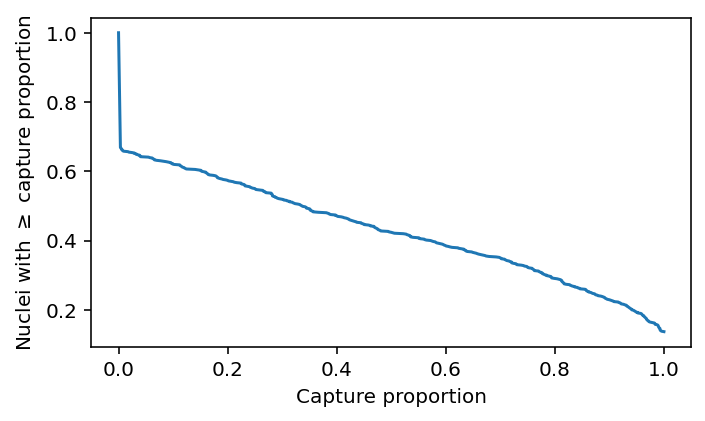

In [149]:
labels = np.unique(watershed)[1:]
props = []
for label in labels:
    label_mask = watershed == label
    area = label_mask.sum()
    
    intersect = label_mask & est_watershed_mask
    intersect_area = intersect.sum()
    
    props.append(intersect_area / area)

unique, counts = np.unique(props, return_counts=True)
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.plot(unique, np.cumsum(counts[::-1])[::-1] / len(props))
ax.set_xlabel('Capture proportion')
ax.set_ylabel('Nuclei with $\geq$ capture proportion')

How about the nuclei labeling itself? Can we accurately assign each individual captured nucleus? We will now compare the consistency of the labeling.

Text(0.5, 1.0, 'RNA labels')

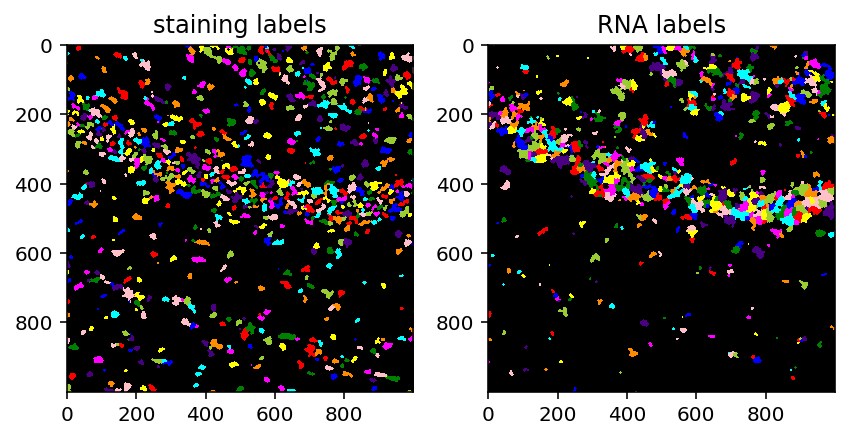

In [134]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)

axes[0].imshow(skimage.color.label2rgb(watershed))
axes[0].set_title('staining labels')

axes[1].imshow(skimage.color.label2rgb(est_watershed))
axes[1].set_title('RNA labels')

Since we already calculated the false positive and false negative rates above, we will only focus on pixels that are occupied in both masks.

Text(0.5, 1.0, 'Adjusted rand score = 0.630')

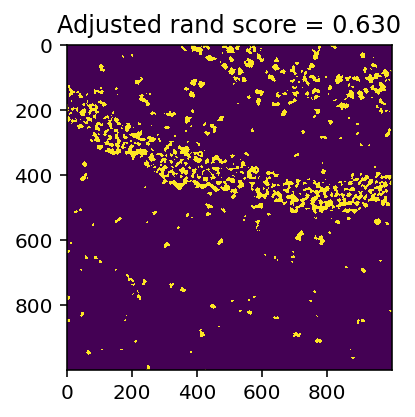

In [155]:
mask = (watershed_mask & est_watershed_mask)
ars = sklearn.metrics.adjusted_rand_score(
    watershed.flatten()[mask.flatten()],
    est_watershed.flatten()[mask.flatten()]
)
fig, ax = plt.subplots(figsize=(3, 3), tight_layout=True)
ax.imshow(mask)
ax.set_title(f'Adjusted rand score = {ars:.3f}')